## Compare LightGBM in the case of binary class (Sell, Buy)

In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
import lightgbm as lgb
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    plot_feature_imp,
    plot_strategy,
    backtest_strategy,
    display_report,
    objective_lightgbm,
    select_threshold,
)

In [2]:
METRIC = "precision"
TEST_SIZE = 199
FPR_MAX = 0.05
TIMEOUT = 600

In [3]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [5]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [7]:
interest_rate = wk_df["r"].values

## Baseline LightGBM Classifier without new data

In [8]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [9]:
# orig_df["r"] = interest_rate

### Split dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [11]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_lightgbm(trial, X_train, y_train, METRIC),
    n_trials=150,
    timeout=TIMEOUT,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-14 19:46:12,001] A new study created in memory with name: no-name-2ccf6203-54b4-40c6-bcce-d5c3afd4f798
[I 2024-02-14 19:46:13,668] Trial 0 finished with value: 0.6506294930714461 and parameters: {'lambda_l1': 7.404718208036244e-05, 'lambda_l2': 0.0017734167489736213, 'num_leaves': 242, 'feature_fraction': 0.5157500776564684, 'bagging_fraction': 0.9559495145396355, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 0 with value: 0.6506294930714461.
[I 2024-02-14 19:46:14,133] Trial 1 finished with value: 0.6549001071479341 and parameters: {'lambda_l1': 4.4622527237644664e-05, 'lambda_l2': 0.001522988392116389, 'num_leaves': 243, 'feature_fraction': 0.4941731326532077, 'bagging_fraction': 0.9532107188094674, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 1 with value: 0.6549001071479341.
[I 2024-02-14 19:46:14,405] Trial 2 finished with value: 0.650811618732114 and parameters: {'lambda_l1': 3.935812964529853e-08, 'lambda_l2': 6.940568812421573e-08, 'num_lea

Number of finished trials: 150
Best trial:
  Value: 0.6696319036303189
  Params: 
    lambda_l1: 7.558022184314637e-06
    lambda_l2: 4.276225688940782
    num_leaves: 74
    feature_fraction: 0.6319795268783425
    bagging_fraction: 0.9151058491033037
    bagging_freq: 2
    min_child_samples: 28


In [12]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **trial.params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": "average_precision",
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [13]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.9151058491033037,
                                bagging_freq=2,
                                feature_fraction=0.6319795268783425,
                                lambda_l1=7.558022184314637e-06,
                                lambda_l2=4.276225688940782,
                                metric='average_precision',
                                min_child_samples=28, num_leaves=74,
                                objective='binary', random_state=1968,
                                verbosity=-1))])

In [14]:
# In-sample score
pipe.score(X_train, y_train)

0.9090183559457302

In [15]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.58


In [16]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [17]:
pipe.score(X_test, y_test)

0.6381909547738693

              precision    recall  f1-score   support

           0       0.56      0.82      0.67        98
           1       0.68      0.39      0.49       101

    accuracy                           0.60       199
   macro avg       0.62      0.60      0.58       199
weighted avg       0.62      0.60      0.58       199



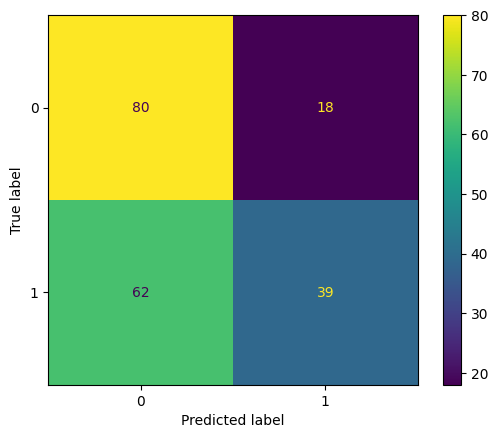

In [18]:
display_report(y_test, predictions)

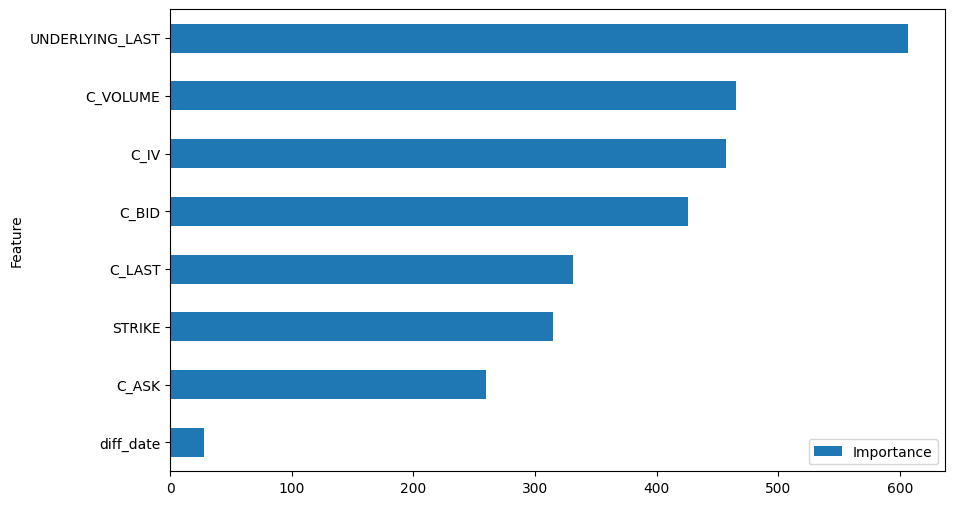

In [19]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [20]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_out"])

### Backtesting

In [21]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [22]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-01-04,1,384.0,7.46,2023-01-27,405.679993,14.219993,14.219993,14.219993,14.219993
2023-01-05,1,379.0,8.50,2023-01-27,405.679993,18.179993,18.179993,32.399985,32.399985
2023-01-06,1,388.0,7.72,2023-01-27,405.679993,9.959993,9.959993,42.359978,42.359978
2023-01-09,1,388.0,7.46,2023-01-27,405.679993,10.219993,10.219993,52.579971,52.579971
2023-01-11,0,395.0,9.11,2023-02-03,412.350006,0.000000,8.240006,52.579971,60.819977
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,283.599958,404.169901
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,283.599958,401.149894
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,283.599958,401.389886


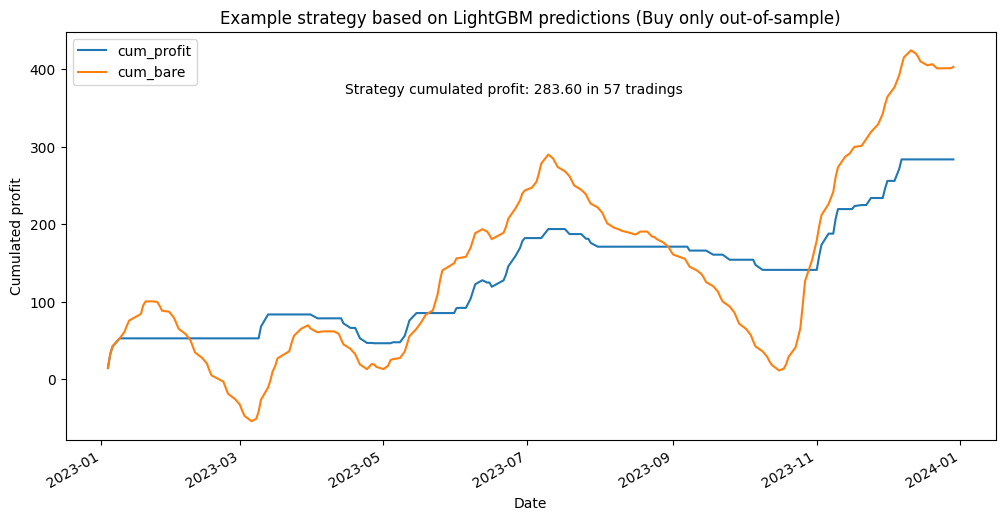

In [23]:
plot_strategy(strategy_df, "LightGBM", "(Buy only out-of-sample)")

In [24]:
compare_df["cum_profit_out"] = strategy_df["cum_profit"].values

## LightGBM with data from MC simulation and additional features

In [25]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike", "r"], axis=1),
    ),
    axis=1,
)

In [26]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [28]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_lightgbm(trial, X_train, y_train, METRIC),
    n_trials=150,
    timeout=TIMEOUT * 2,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-14 19:47:10,859] A new study created in memory with name: no-name-69a5a3c6-b8a8-4fb6-9736-003032081d9b
[I 2024-02-14 19:47:12,070] Trial 0 finished with value: 0.6901881862037726 and parameters: {'lambda_l1': 7.404718208036244e-05, 'lambda_l2': 0.0017734167489736213, 'num_leaves': 242, 'feature_fraction': 0.5157500776564684, 'bagging_fraction': 0.9559495145396355, 'bagging_freq': 5, 'min_child_samples': 30}. Best is trial 0 with value: 0.6901881862037726.
[I 2024-02-14 19:47:12,858] Trial 1 finished with value: 0.7036367006494477 and parameters: {'lambda_l1': 4.4622527237644664e-05, 'lambda_l2': 0.001522988392116389, 'num_leaves': 243, 'feature_fraction': 0.4941731326532077, 'bagging_fraction': 0.9532107188094674, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 1 with value: 0.7036367006494477.
[I 2024-02-14 19:47:13,276] Trial 2 finished with value: 0.6933868483528519 and parameters: {'lambda_l1': 3.935812964529853e-08, 'lambda_l2': 6.940568812421573e-08, 'num_le

Number of finished trials: 150
Best trial:
  Value: 0.7177321616669871
  Params: 
    lambda_l1: 8.923750881342898e-08
    lambda_l2: 0.10609136314237398
    num_leaves: 243
    feature_fraction: 0.5458799022732909
    bagging_fraction: 0.8523769916993678
    bagging_freq: 3
    min_child_samples: 16


In [29]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **study.best_params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": "average_precision",
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [30]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.8523769916993678,
                                bagging_freq=3,
                                feature_fraction=0.5458799022732909,
                                lambda_l1=8.923750881342898e-08,
                                lambda_l2=0.10609136314237398,
                                metric='average_precision',
                                min_child_samples=16, num_leaves=243,
                                objective='binary', random_state=1968,
                                verbosity=-1))])

In [31]:
# In-sample score
pipe.score(X_train, y_train)

1.0

In [32]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.77


In [33]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [34]:
pipe.score(X_test, y_test)

0.5829145728643216

              precision    recall  f1-score   support

           0       0.56      0.73      0.63        98
           1       0.63      0.44      0.51       101

    accuracy                           0.58       199
   macro avg       0.59      0.59      0.57       199
weighted avg       0.59      0.58      0.57       199



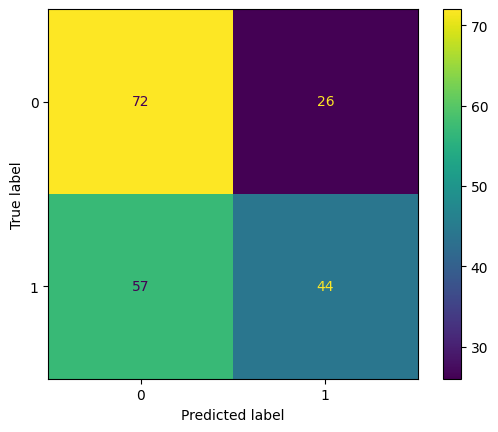

In [35]:
display_report(y_test, predictions)

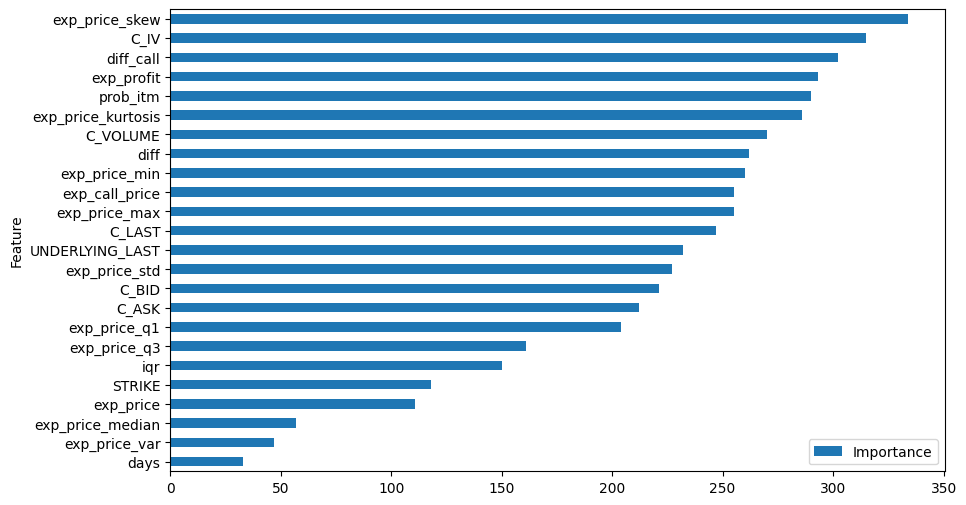

In [36]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [37]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [38]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [39]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-01-04,1,384.0,7.46,2023-01-27,405.679993,14.219993,14.219993,14.219993,14.219993
2023-01-05,1,379.0,8.50,2023-01-27,405.679993,18.179993,18.179993,32.399985,32.399985
2023-01-06,1,388.0,7.72,2023-01-27,405.679993,9.959993,9.959993,42.359978,42.359978
2023-01-09,0,388.0,7.46,2023-01-27,405.679993,0.000000,10.219993,42.359978,52.579971
2023-01-11,0,395.0,9.11,2023-02-03,412.350006,0.000000,8.240006,42.359978,60.819977
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,301.099945,404.169901
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,301.099945,401.149894
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,301.099945,401.389886


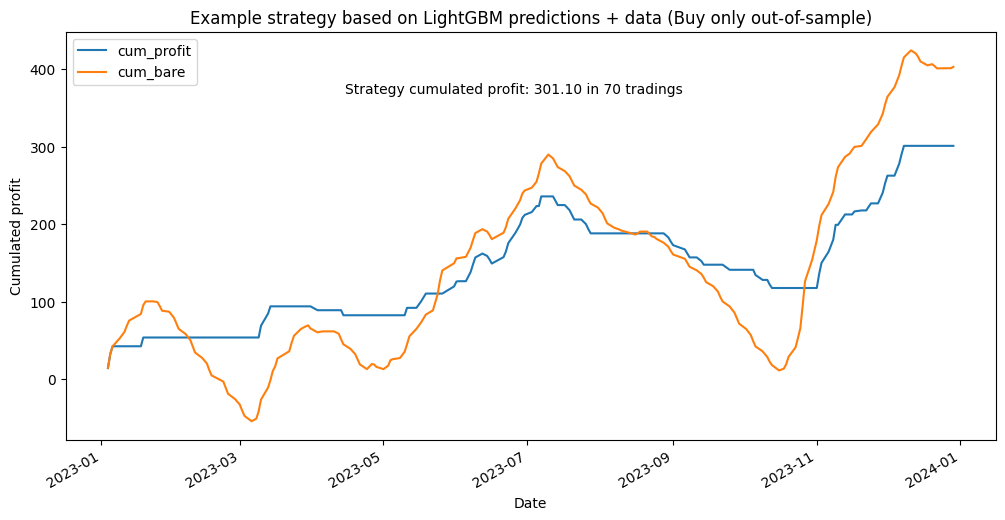

In [40]:
plot_strategy(strategy_df, "LightGBM", "+ data (Buy only out-of-sample)")

In [41]:
compare_df["mmar_cum_profit_out"] = strategy_df["cum_profit"].values
compare_df["mmar_cum_bare_out"] = strategy_df["cum_bare"].values

## Compare the two predictions

In [42]:
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [43]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_out,cum_profit_out,mmar_rf_pred_out,mmar_cum_profit_out,mmar_cum_bare_out
3,1,52.579971,0,42.359978,52.579971
8,0,52.579971,1,53.669987,95.360006
38,0,83.420000,1,93.900018,-1.519877
56,1,66.040010,0,82.400028,38.990133
58,1,59.330010,0,82.400028,25.480133
59,1,52.720010,0,82.400028,18.870133
60,1,46.680010,0,82.400028,12.830133
62,1,46.270005,0,82.400028,18.920123
67,1,47.529994,0,82.400028,25.750081
69,1,55.730007,0,82.400028,35.340083


In [44]:
compare_df[mask_out].shape

(43, 5)

In [45]:
compare_df.sum(axis=0)

bare_rf_pred_out          57.000000
cum_profit_out         26567.658229
mmar_rf_pred_out          70.000000
mmar_cum_profit_out    28315.756996
mmar_cum_bare_out      28399.674850
dtype: float64

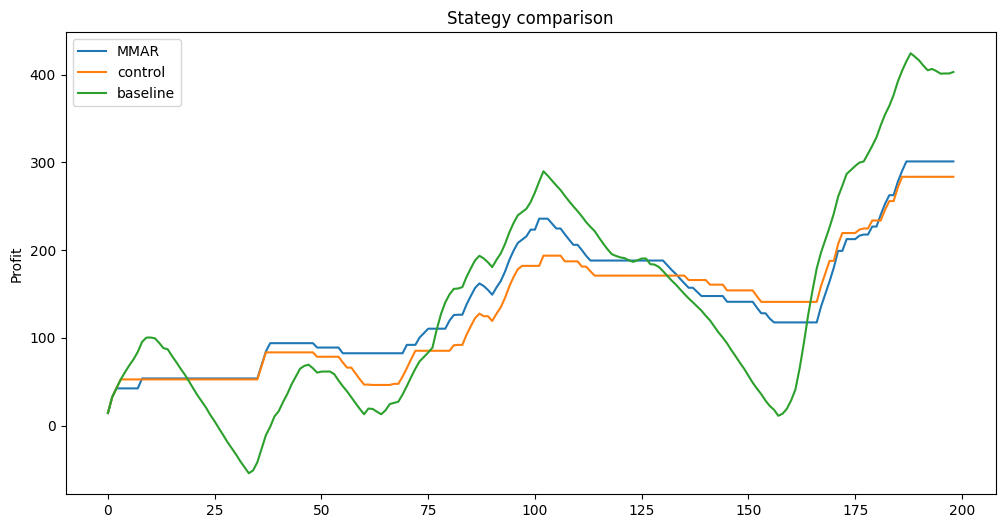

In [48]:
compare_df[["mmar_cum_profit_out", "cum_profit_out", "mmar_cum_bare_out"]].rename(
    {
        "mmar_cum_profit_out": "MMAR",
        "cum_profit_out": "control",
        "mmar_cum_bare_out": "baseline",
    },
    axis=1,
).plot(figsize=(12, 6), title="Stategy comparison", ylabel="Profit")